In [1]:
import sys
sys.path.insert(1, '/home/glenn/src/latent_ode/')
from generate_timeseries import *
import pdb

In [2]:
from torch.utils.data import DataLoader

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
%matplotlib inline

In [5]:
init = 0
# final = 1

In [6]:
tmax = 500
tmin = 0
xs = np.arange(tmin, tmax)

In [7]:
ts = np.sort(np.random.choice(xs, 100))

In [8]:
ts

array([  1,  20,  21,  23,  24,  24,  24,  28,  33,  39,  43,  44,  56,
        60,  63,  68,  77,  79,  84,  86,  90,  91, 101, 109, 110, 113,
       113, 120, 120, 123, 127, 127, 128, 128, 130, 131, 135, 137, 140,
       140, 146, 157, 167, 169, 181, 186, 194, 208, 244, 246, 248, 249,
       257, 262, 264, 266, 266, 271, 271, 295, 297, 300, 304, 308, 316,
       318, 320, 323, 337, 337, 339, 340, 342, 345, 347, 357, 360, 363,
       370, 376, 378, 383, 384, 397, 398, 405, 410, 423, 431, 432, 434,
       435, 443, 446, 461, 471, 487, 496, 498, 498])

In [9]:
generate_periodic(xs[0:1], init_freq=0.1, init_amplitude=init, starting_point=0, phi_offset=0.)

array([[0., 0.]])

In [10]:
f = Periodic_1d()

In [11]:
x = f.sample_traj(ts)
x_np = x.squeeze().detach().cpu().numpy()

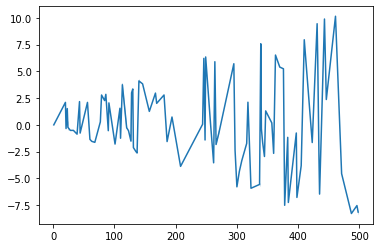

In [12]:
sns.lineplot(x=ts, y=x_np)

In [13]:
l = int(x.size(1)*0.8)

In [14]:
x_train = x[0][:l]
x_test = x[0][l:]

In [15]:
ts = torch.Tensor(ts)

In [16]:
ts.shape

torch.Size([100])

In [17]:
ts_train = ts[:l]
ts_test = ts[l:]

In [18]:
ts_test

tensor([378., 383., 384., 397., 398., 405., 410., 423., 431., 432., 434., 435.,
        443., 446., 461., 471., 487., 496., 498., 498.])

In [19]:
dataset = f.sample_traj(ts, n_samples = 32, noise_weight = 0.2)

In [20]:
dataset.shape

torch.Size([32, 100, 1])

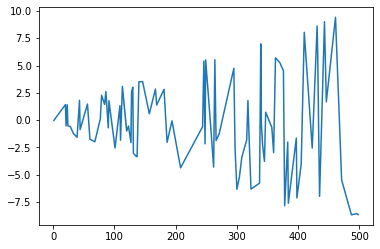

In [21]:
sns.lineplot(x=ts, y=dataset[10].squeeze().numpy())

In [22]:
dataset.shape

torch.Size([32, 100, 1])

In [23]:
L = 80

In [24]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, xs):
        self.xs = xs

    def __getitem__(self, i):
        x = self.xs[i]
        return x
    
    def __len__(self):
        return len(self.xs)

In [25]:
ix = int(0.8*len(dataset))
train_ds = TSDataset(dataset[:ix])
test_ds = TSDataset(dataset[ix:])

In [31]:
def collate_fn(batch):
    batch = torch.stack(batch)
    inps = batch[:, :L, :]
    outps = batch[:, L:, :]
    return inps, outps

In [38]:
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=len(x_test), collate_fn=collate_fn)

In [39]:
a = next(iter(train_loader))

In [34]:
xs, ys = a

In [42]:
xs.shape

torch.Size([4, 80, 1])

In [ ]:
model = LatentODE(
		input_dim = 1, 
		latent_dim = 12, 
		encoder_z0 = encoder_z0, 
		decoder = decoder, 
		diffeq_solver = diffeq_solver, 
		z0_prior = z0_prior, 
		device = device,
		obsrv_std = obsrv_std,
		use_poisson_proc = args.poisson, 
		use_binary_classif = args.classif,
		linear_classifier = args.linear_classif,
		classif_per_tp = classif_per_tp,
		n_labels = n_labels,
		train_classif_w_reconstr = (args.dataset == "physionet")
		).to(device)